In [1]:
!pip install git+https://github.com/ContinualAI/avalanche.git


  Cloning https://github.com/ContinualAI/avalanche.git to /tmp/pip-req-build-xqfhv3xk
  Running command git clone -q https://github.com/ContinualAI/avalanche.git /tmp/pip-req-build-xqfhv3xk
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 121 kB 46.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 532 kB 45.2 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 139 kB 45.4 MB/s 
     |████████████████████████████████| 180 kB 47.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for avalanche-lib: filename=avalanche_lib-0.0.1-py3-none-any.whl size=426447 sha256=c534c3e0e78d00039aeae3566e33b17ca3567614f7c4d5ff41e17c601

In [2]:
from avalanche.benchmarks.classic.ccifar10 import SplitCIFAR10
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,\
    loss_metrics, timing_metrics, cpu_usage_metrics, StreamConfusionMatrix,\
    disk_usage_metrics, gpu_usage_metrics
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.strategies import Naive,LwF,EWC

from torch.optim import SGD
from torch.nn import CrossEntropyLoss,NLLLoss
import copy

In [3]:
from avalanche.benchmarks.datasets import CIFAR10
epochss=2
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight.data, gain=1)
def weights_init2(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight.data,gain=2)
def weights_init3(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight.data,gain=3)
def weights_init4(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight.data,gain=4)
def weights_init5(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight.data,gain=5)
# kaiming_normal_(Tensor tensor, double a = 0, FanModeType mode = torch::kFanIn, NonlinearityType nonlinearity = torch::kLeakyReLU)
def weights_init6(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight.data,0,mode='fan_in')
def weights_init7(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight.data,0,mode='fan_out')

In [5]:
scenario = SplitCIFAR10(n_experiences=5,return_task_id=True)
from avalanche.models import SimpleCNN
from avalanche.models import SimpleMLP_TinyImageNet

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/cifar10/cifar-10-python.tar.gz to /root/.avalanche/data/cifar10
Files already downloaded and verified


In [6]:
import torch.nn as nn
import torch.nn.functional as F
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        
        # Initial input conv
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=(3, 3),
            stride=1, padding=1, bias=False
        )
        

        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 =nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(3, 3),
            stride=2, padding=1, bias=False
        )
        self.conv3 =nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=(3, 3),
            stride=2, padding=1, bias=False
        )
        self.conv4 =nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=(3, 3),
            stride=2, padding=1, bias=False
        )
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
model=ResNet()
model.apply(weights_init)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

In [8]:
one00 = model.state_dict()['conv1.weight'].cpu()

In [9]:
torch.std((one00[0:,0:1,0:,0].flatten()))

tensor(0.0592)

In [10]:
torch.mean((one00[0:,0:1,0:,0].flatten()))

tensor(0.0026)

In [11]:
torch.std(model.state_dict()['conv1.weight'].cpu().flatten(), unbiased=False)

tensor(0.0575)

In [12]:
torch.mean(model.state_dict()['conv1.weight'].cpu().flatten())

tensor(1.4068e-05)

In [13]:
tb_logger = TensorboardLogger(tb_log_dir = './tb_data1')
text_logger = TextLogger(open('log.txt', 'a'))

eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=False, experience=True),
    loss_metrics(minibatch=False, stream=False),
    forgetting_metrics(experience=True, stream=True), 
    loggers=[InteractiveLogger(), tb_logger])

cl_strategy = EWC(
      model, SGD(model.parameters(), lr=.0001, momentum=0.9),
      CrossEntropyLoss(), ewc_lambda=.4, train_mb_size=500, train_epochs=epochss, eval_mb_size=100,
      evaluator=eval_plugin, device=device)

/usr/local/lib/python3.7/dist-packages/avalanche/training/plugins/evaluation.py:84: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  "No benchmark provided to the evaluation plugin. "


## FIRST **INITIALIZATION**

In [14]:
  print('Starting experiment...')
  results = []
  for train_batch_info in scenario.train_stream[0:1]:
      print("Start training on experience ", train_batch_info.current_experience)

      cl_strategy.train(train_batch_info, num_workers=4)
      print("End training on experience ", train_batch_info.current_experience)
      print('Computing accuracy on the test set')
      results.append(cl_strategy.eval(scenario.test_stream[0:2]))

Starting experiment...
Start training on experience  0
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
Epoch 0 ended.
100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
Epoch 1 ended.
-- >> End of training phase << --
End training on experience  0
Computing accuracy on the test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 13.24it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7005
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 20/20 [00:01<00:00, 16.29it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.3200
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.0000


In [15]:
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

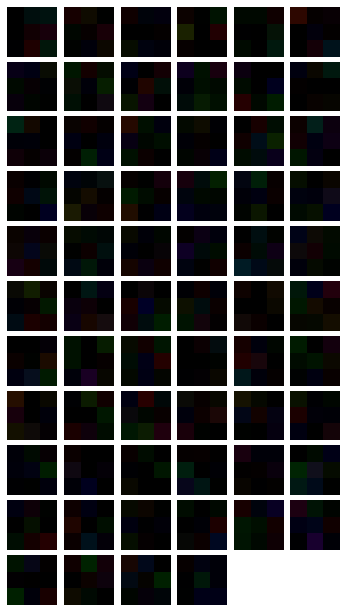

In [16]:
from matplotlib import pyplot as plt

def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))

    # print(torch.std(tensor,axis=0))
    # min=10000
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        std = torch.std(tensor)
        ax1.imshow(tensor[i])
        # print(tensor[i]+torch.tensor([[[1,1,1]]]))
        # print(max(tensor[i],axis=2))
        # print(torch.std(tensor))
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
plot_kernels(model.state_dict()['conv1.weight'].cpu())
one = copy.deepcopy(model.state_dict()['conv1.weight'].cpu())

In [17]:
torch.std(model.state_dict()['conv1.weight'].cpu().flatten(), unbiased=False)

tensor(0.0575)

In [18]:
torch.mean(model.state_dict()['conv1.weight'].cpu().flatten())

tensor(8.3413e-05)

In [19]:
torch.std((one[0:,0:1,0:,0].flatten()))

tensor(0.0591)

In [20]:
torch.mean((one[0:,0:1,0:,0].flatten()))

tensor(0.0026)

## SECOND **INITIALIZATION**

In [21]:
model.apply(weights_init2)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

In [22]:
  print('Starting experiment...')
  results = []
  for train_batch_info in scenario.train_stream[1:2]:
      print("Start training on experience ", train_batch_info.current_experience)

      cl_strategy.train(train_batch_info, num_workers=4)
      print("End training on experience ", train_batch_info.current_experience)
      print('Computing accuracy on the test set')
      results.append(cl_strategy.eval(scenario.test_stream[0:2]))

Starting experiment...
Start training on experience  1
-- >> Start of training phase << --
-- Starting training on experience 1 (Task 1) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
Epoch 0 ended.
100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
Epoch 1 ended.
-- >> End of training phase << --
End training on experience  1
Computing accuracy on the test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 13.28it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.4160
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.2845
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 20/20 [00:01<00:00, 15.81it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.6855
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.4160


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

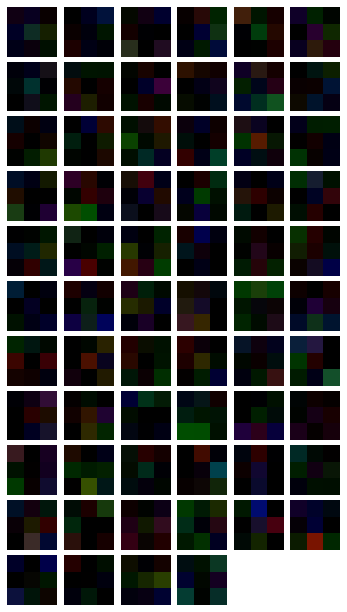

In [23]:
from matplotlib import pyplot as plt

def plot_kernels2(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
plot_kernels2(model.state_dict()['conv1.weight'].cpu())
two = copy.deepcopy(model.state_dict()['conv1.weight'].cpu())

## THIRD **INITIALIZATION** 

In [24]:
model.apply(weights_init3)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

In [25]:
  print('Starting experiment...')
  results = []
  for train_batch_info in scenario.train_stream[1:2]:
      print("Start training on experience ", train_batch_info.current_experience)

      cl_strategy.train(train_batch_info, num_workers=4)
      print("End training on experience ", train_batch_info.current_experience)
      print('Computing accuracy on the test set')
      results.append(cl_strategy.eval(scenario.test_stream[0:2]))

Starting experiment...
Start training on experience  1
-- >> Start of training phase << --
-- Starting training on experience 1 (Task 1) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
Epoch 0 ended.
100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
Epoch 1 ended.
-- >> End of training phase << --
End training on experience  1
Computing accuracy on the test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 13.34it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.3535
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.3470
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 20/20 [00:01<00:00, 16.16it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.6365
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.3535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

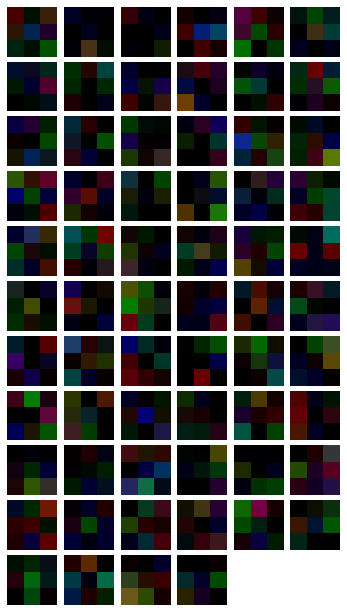

In [26]:
from matplotlib import pyplot as plt

def plot_kernels3(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
plot_kernels3(model.state_dict()['conv1.weight'].cpu())
three = copy.deepcopy(model.state_dict()['conv1.weight'].cpu())

## FOURTH **INITIALIZATION**

In [27]:
model.apply(weights_init4)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

In [28]:
  print('Starting experiment...')
  results = []
  for train_batch_info in scenario.train_stream[1:2]:
      print("Start training on experience ", train_batch_info.current_experience)

      cl_strategy.train(train_batch_info, num_workers=4)
      print("End training on experience ", train_batch_info.current_experience)
      print('Computing accuracy on the test set')
      results.append(cl_strategy.eval(scenario.test_stream[0:2]))

Starting experiment...
Start training on experience  1
-- >> Start of training phase << --
-- Starting training on experience 1 (Task 1) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
Epoch 0 ended.
100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
Epoch 1 ended.
-- >> End of training phase << --
End training on experience  1
Computing accuracy on the test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 13.64it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.3740
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.3265
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 20/20 [00:01<00:00, 16.16it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.6465
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.3740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

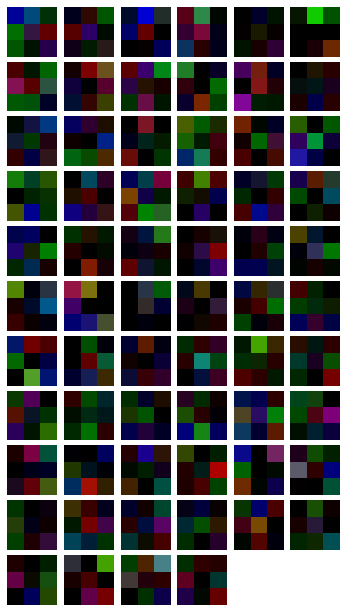

In [29]:
from matplotlib import pyplot as plt

def plot_kernels4(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
plot_kernels4(model.state_dict()['conv1.weight'].cpu())
four = copy.deepcopy(model.state_dict()['conv1.weight'].cpu())

## FIFTH **INITIALIZATION**

In [30]:
model.apply(weights_init5)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

In [31]:
  print('Starting experiment...')
  results = []
  for train_batch_info in scenario.train_stream[1:2]:
      print("Start training on experience ", train_batch_info.current_experience)

      cl_strategy.train(train_batch_info, num_workers=4)
      print("End training on experience ", train_batch_info.current_experience)
      print('Computing accuracy on the test set')
      results.append(cl_strategy.eval(scenario.test_stream[0:2]))

Starting experiment...
Start training on experience  1
-- >> Start of training phase << --
-- Starting training on experience 1 (Task 1) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
Epoch 0 ended.
100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
Epoch 1 ended.
-- >> End of training phase << --
End training on experience  1
Computing accuracy on the test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 13.36it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.2360
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4645
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 20/20 [00:01<00:00, 16.06it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.5305
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.2360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

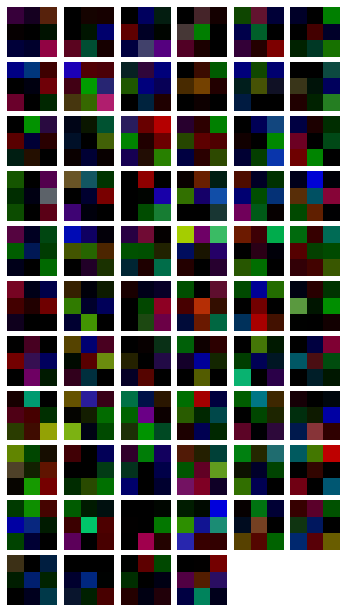

In [32]:
from matplotlib import pyplot as plt

def plot_kernels5(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
plot_kernels5(model.state_dict()['conv1.weight'].cpu())
five = copy.deepcopy(model.state_dict()['conv1.weight'].cpu())

In [33]:
temp = model.state_dict()['conv1.weight'].cpu()

# Kaiming

### **6th initialization**

Starting experiment...
Start training on experience  1
-- >> Start of training phase << --
-- Starting training on experience 1 (Task 1) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
Epoch 0 ended.
100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
Epoch 1 ended.
-- >> End of training phase << --
End training on experience  1
Computing accuracy on the test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 13.36it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.4180
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.2825
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 20/20 [00:01<00:00, 16.24it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.6925
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.4180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

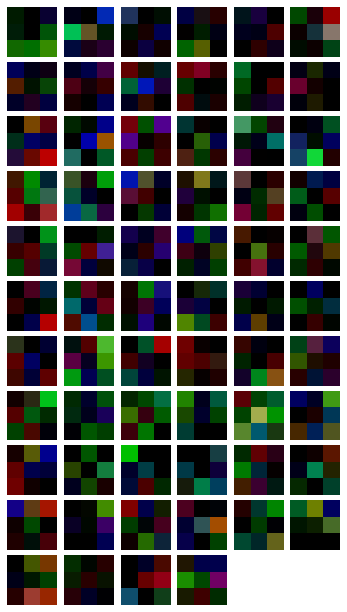

In [34]:
model.apply(weights_init6)
print('Starting experiment...')

results = []
for train_batch_info in scenario.train_stream[1:2]:
    print("Start training on experience ", train_batch_info.current_experience)

    cl_strategy.train(train_batch_info, num_workers=4)
    print("End training on experience ", train_batch_info.current_experience)
    print('Computing accuracy on the test set')
    results.append(cl_strategy.eval(scenario.test_stream[0:2]))


plot_kernels5(model.state_dict()['conv1.weight'].cpu())
six = copy.deepcopy(model.state_dict()['conv1.weight'].cpu())

### **7th initialization**

Starting experiment...
Start training on experience  1
-- >> Start of training phase << --
-- Starting training on experience 1 (Task 1) from train stream --


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
Epoch 0 ended.
100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
Epoch 1 ended.
-- >> End of training phase << --
End training on experience  1
Computing accuracy on the test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 20/20 [00:01<00:00, 13.53it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.2665
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4340
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 20/20 [00:01<00:00, 15.96it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.5820
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.2665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

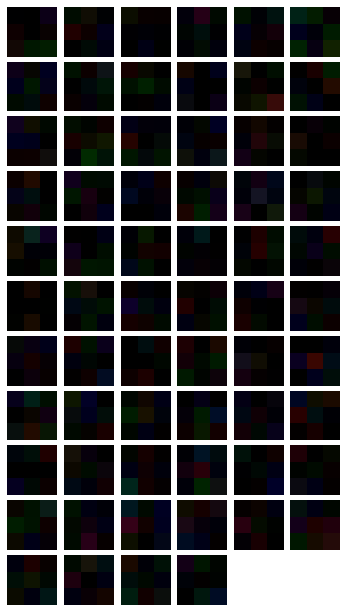

In [35]:
model.apply(weights_init7)
print('Starting experiment...')

results = []
for train_batch_info in scenario.train_stream[1:2]:
    print("Start training on experience ", train_batch_info.current_experience)

    cl_strategy.train(train_batch_info, num_workers=4)
    print("End training on experience ", train_batch_info.current_experience)
    print('Computing accuracy on the test set')
    results.append(cl_strategy.eval(scenario.test_stream[0:2]))


plot_kernels5(model.state_dict()['conv1.weight'].cpu())
seven = copy.deepcopy(model.state_dict()['conv1.weight'].cpu())

# Plot Weights


### **Comparing 1 with 2**

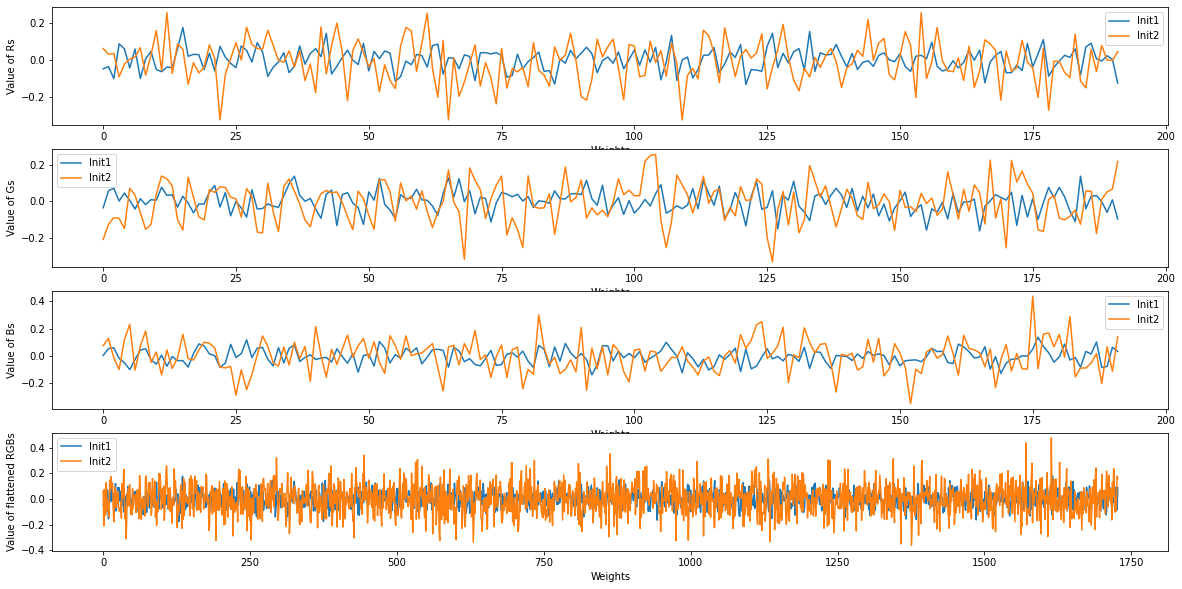

In [36]:
f2 = plt.figure()
f2.set_figwidth(20)
f2.set_figheight(10)
plt.subplot(411,xlabel="Weights",ylabel="Value of Rs")
plt.plot(one[0:,0:1,0:,0].flatten())
plt.plot(two[0:,0:1,0:,0].flatten())
plt.legend(["Init1", "Init2"])
plt.subplot(412,xlabel="Weights",ylabel="Value of Gs")
plt.plot(one[0:,0:1,0:,1].flatten())
plt.plot(two[0:,0:1,0:,1].flatten())
plt.legend(["Init1", "Init2"])

plt.subplot(413,xlabel="Weights",ylabel="Value of Bs")
plt.plot(one[0:,0:1,0:,2].flatten())
plt.plot(two[0:,0:1,0:,2].flatten())
plt.legend(["Init1", "Init2"])

plt.subplot(414,xlabel="Weights",ylabel="Value of flattened RGBs")
plt.plot(one.flatten())
plt.plot(two.flatten())
plt.legend(["Init1", "Init2"])



### **Comparing 1 with 3**

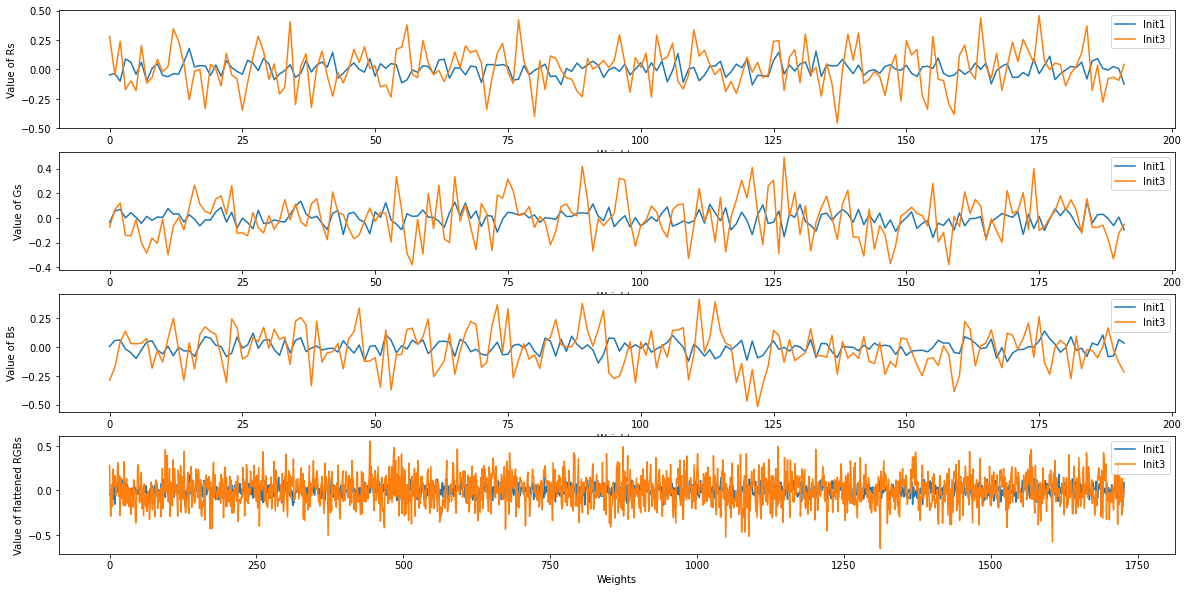

In [37]:
f2 = plt.figure()
f2.set_figwidth(20)
f2.set_figheight(10)
plt.subplot(411,xlabel="Weights",ylabel="Value of Rs")
plt.plot(one[0:,0:1,0:,0].flatten())
plt.plot(three[0:,0:1,0:,0].flatten())
plt.legend(["Init1", "Init3"])

plt.subplot(412,xlabel="Weights",ylabel="Value of Gs")
plt.plot(one[0:,0:1,0:,1].flatten())
plt.plot(three[0:,0:1,0:,1].flatten())
plt.legend(["Init1", "Init3"])

plt.subplot(413,xlabel="Weights",ylabel="Value of Bs")
plt.plot(one[0:,0:1,0:,2].flatten())
plt.plot(three[0:,0:1,0:,2].flatten())
plt.legend(["Init1", "Init3"])

plt.subplot(414,xlabel="Weights",ylabel="Value of flattened RGBs")
plt.plot(one.flatten())
plt.plot(three.flatten())
plt.legend(["Init1", "Init3"])


### **Comparing 1 with 4**

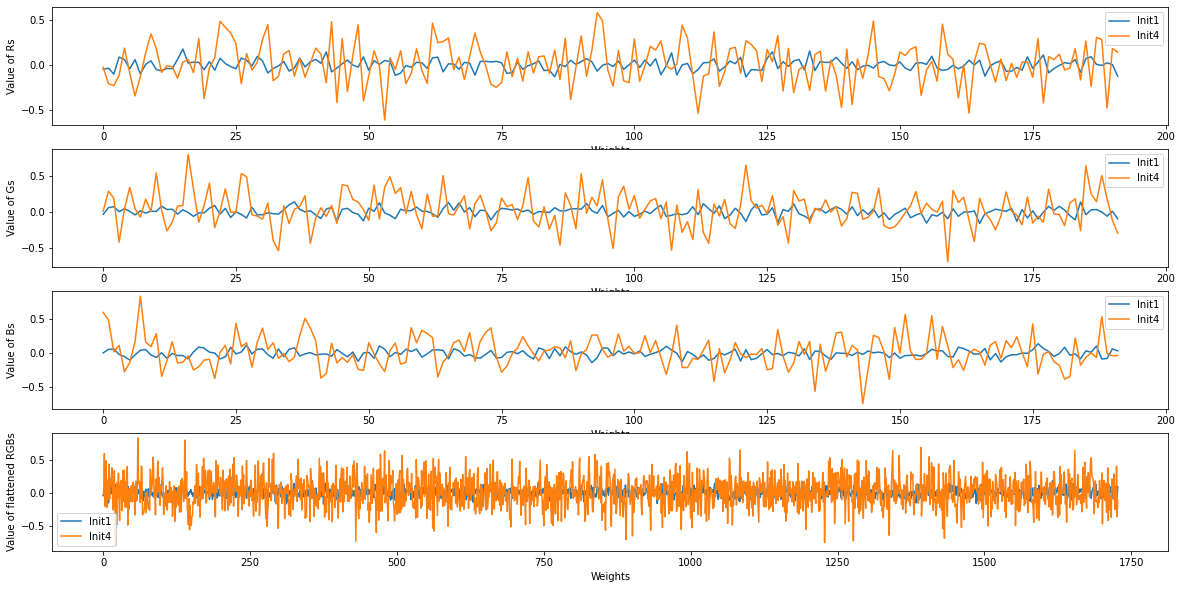

In [38]:
f2 = plt.figure()
f2.set_figwidth(20)
f2.set_figheight(10)
plt.subplot(411,xlabel="Weights",ylabel="Value of Rs")
plt.plot(one[0:,0:1,0:,0].flatten())
plt.plot(four[0:,0:1,0:,0].flatten())
plt.legend(["Init1", "Init4"])

plt.subplot(412,xlabel="Weights",ylabel="Value of Gs")
plt.plot(one[0:,0:1,0:,1].flatten())
plt.plot(four[0:,0:1,0:,1].flatten())
plt.legend(["Init1", "Init4"])

plt.subplot(413,xlabel="Weights",ylabel="Value of Bs")
plt.plot(one[0:,0:1,0:,2].flatten())
plt.plot(four[0:,0:1,0:,2].flatten())
plt.legend(["Init1", "Init4"])

plt.subplot(414,xlabel="Weights",ylabel="Value of flattened RGBs")
plt.plot(one.flatten())
plt.plot(four.flatten())
plt.legend(["Init1", "Init4"])


### **Comparing 1 with 5**

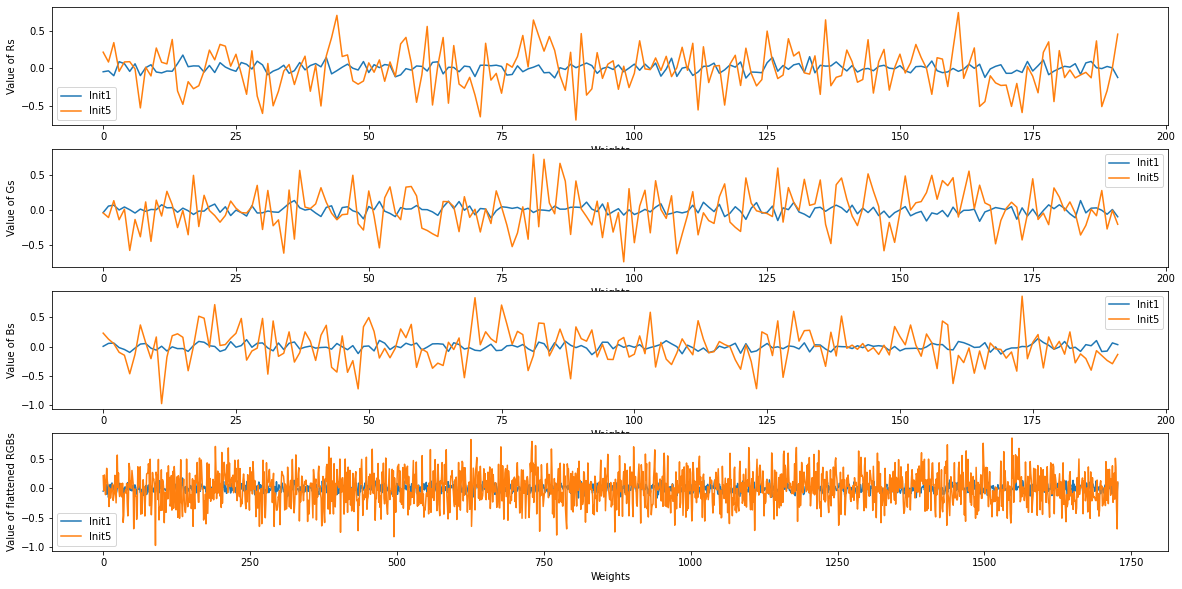

In [39]:
f2 = plt.figure()
f2.set_figwidth(20)
f2.set_figheight(10)
plt.subplot(411,xlabel="Weights",ylabel="Value of Rs")
plt.plot(one[0:,0:1,0:,0].flatten())
plt.plot(five[0:,0:1,0:,0].flatten())
plt.legend(["Init1", "Init5"])

plt.subplot(412,xlabel="Weights",ylabel="Value of Gs")
plt.plot(one[0:,0:1,0:,1].flatten())
plt.plot(five[0:,0:1,0:,1].flatten())
plt.legend(["Init1", "Init5"])

plt.subplot(413,xlabel="Weights",ylabel="Value of Bs")
plt.plot(one[0:,0:1,0:,2].flatten())
plt.plot(five[0:,0:1,0:,2].flatten())
plt.legend(["Init1", "Init5"])

plt.subplot(414,xlabel="Weights",ylabel="Value of flattened RGBs")
plt.plot(one.flatten())
plt.plot(five.flatten())
plt.legend(["Init1", "Init5"])


## Kaiming normal Fan-in

### **Comparing 1 with 6**

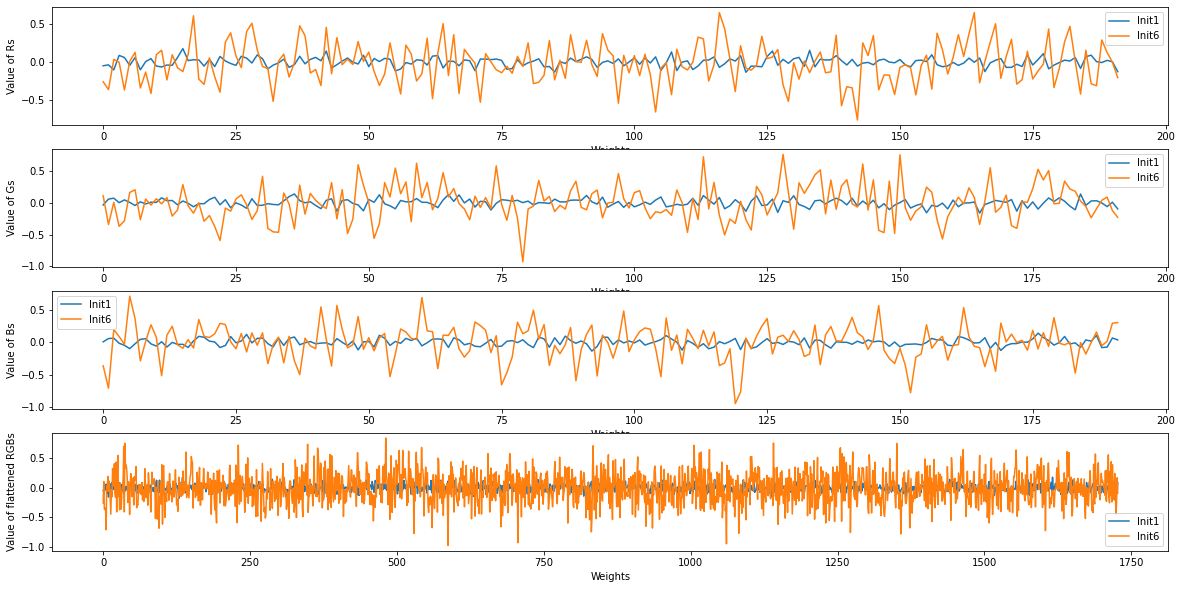

In [40]:
f2 = plt.figure()
f2.set_figwidth(20)
f2.set_figheight(10)
plt.subplot(411,xlabel="Weights",ylabel="Value of Rs")
plt.plot(one[0:,0:1,0:,0].flatten())
plt.plot(six[0:,0:1,0:,0].flatten())
plt.legend(["Init1", "Init6"])

plt.subplot(412,xlabel="Weights",ylabel="Value of Gs")
plt.plot(one[0:,0:1,0:,1].flatten())
plt.plot(six[0:,0:1,0:,1].flatten())
plt.legend(["Init1", "Init6"])

plt.subplot(413,xlabel="Weights",ylabel="Value of Bs")
plt.plot(one[0:,0:1,0:,2].flatten())
plt.plot(six[0:,0:1,0:,2].flatten())
plt.legend(["Init1", "Init6"])

plt.subplot(414,xlabel="Weights",ylabel="Value of flattened RGBs")
plt.plot(one.flatten())
plt.plot(six.flatten())
plt.legend(["Init1", "Init6"])


## Kaiming normal Fan-out

### **Comparing 1 with 7**

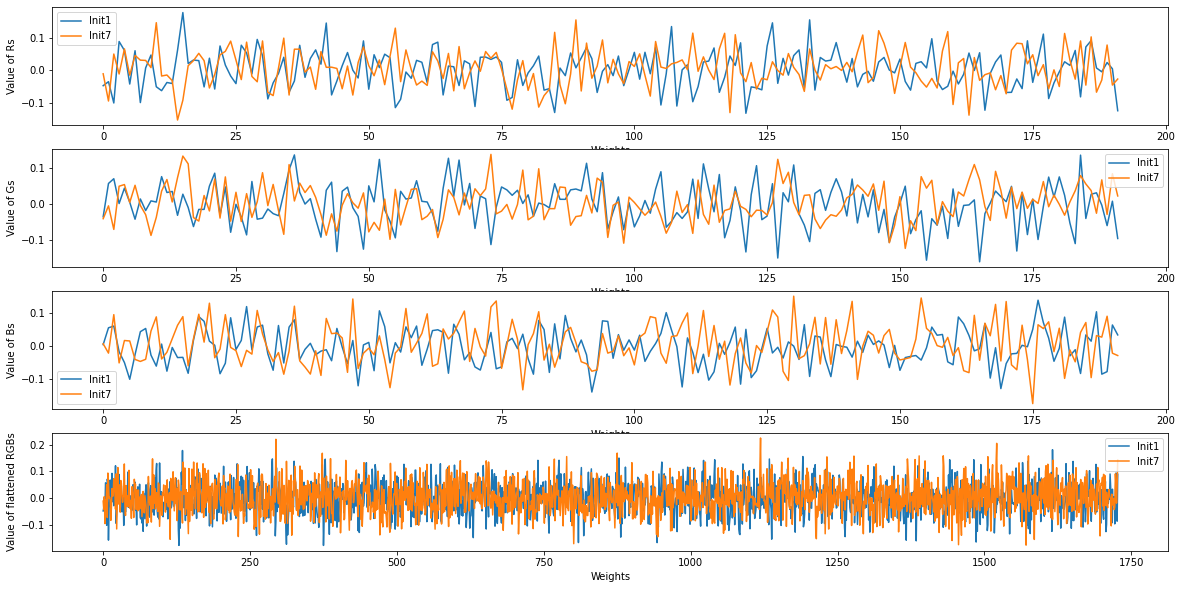

In [41]:
f2 = plt.figure()
f2.set_figwidth(20)
f2.set_figheight(10)
plt.subplot(411,xlabel="Weights",ylabel="Value of Rs")
plt.plot(one[0:,0:1,0:,0].flatten())
plt.plot(seven[0:,0:1,0:,0].flatten())
plt.legend(["Init1", "Init7"])

plt.subplot(412,xlabel="Weights",ylabel="Value of Gs")
plt.plot(one[0:,0:1,0:,1].flatten())
plt.plot(seven[0:,0:1,0:,1].flatten())
plt.legend(["Init1", "Init7"])

plt.subplot(413,xlabel="Weights",ylabel="Value of Bs")
plt.plot(one[0:,0:1,0:,2].flatten())
plt.plot(seven[0:,0:1,0:,2].flatten())
plt.legend(["Init1", "Init7"])

plt.subplot(414,xlabel="Weights",ylabel="Value of flattened RGBs")
plt.plot(one.flatten())
plt.plot(seven.flatten())
plt.legend(["Init1", "Init7"])


Kaiming vs Xavier

### **Comparing 2 with 7**

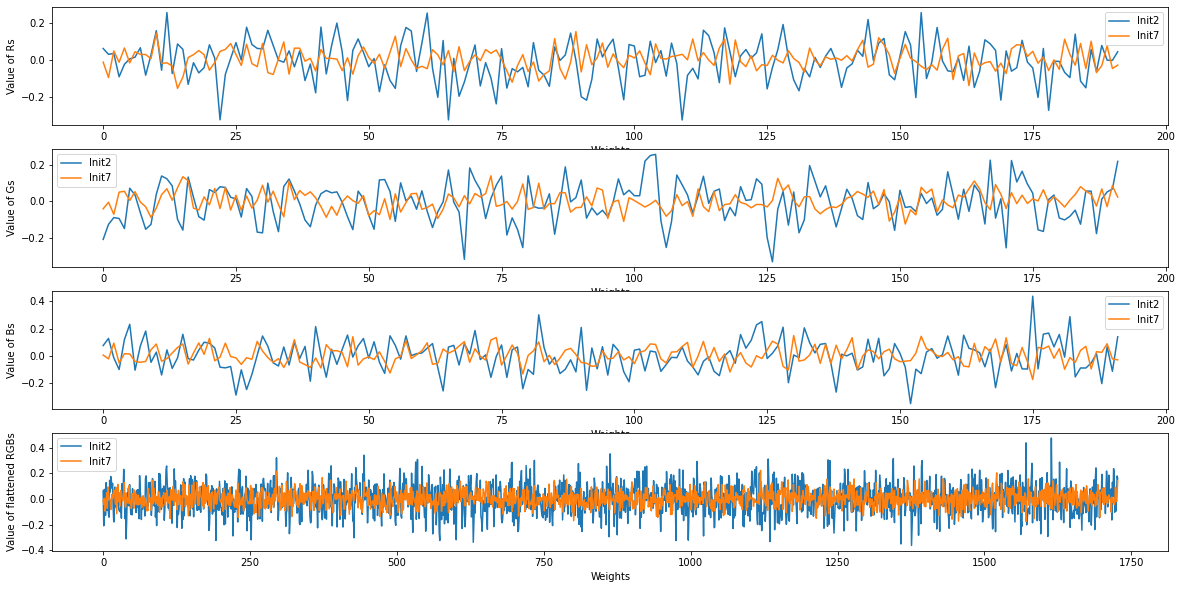

In [42]:
f2 = plt.figure()
f2.set_figwidth(20)
f2.set_figheight(10)
plt.subplot(411,xlabel="Weights",ylabel="Value of Rs")
plt.plot(two[0:,0:1,0:,0].flatten())
plt.plot(seven[0:,0:1,0:,0].flatten())
plt.legend(["Init2", "Init7"])

plt.subplot(412,xlabel="Weights",ylabel="Value of Gs")
plt.plot(two[0:,0:1,0:,1].flatten())
plt.plot(seven[0:,0:1,0:,1].flatten())
plt.legend(["Init2", "Init7"])

plt.subplot(413,xlabel="Weights",ylabel="Value of Bs")
plt.plot(two[0:,0:1,0:,2].flatten())
plt.plot(seven[0:,0:1,0:,2].flatten())
plt.legend(["Init2", "Init7"])

plt.subplot(414,xlabel="Weights",ylabel="Value of flattened RGBs")
plt.plot(two.flatten())
plt.plot(seven.flatten())
plt.legend(["Init2", "Init7"])
